In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Carregar o CSV
df = pd.read_csv("./results/assl_multitask_results.csv")

# Garantir ordenação consistente
df = df.sort_values(["seed", "pretext_task", "lambda_u_max", "round"]).reset_index(drop=True)

# Só por garantia, verificar colunas principais
print(df.columns)


Index(['timestamp', 'dataset', 'img_size', 'pretext_task', 'lambda_pretext',
       'lambda_u_max', 'seed', 'labeled_init', 'rounds', 'budget_per_round',
       'epochs_per_round', 'tau', 'temp_T', 'feat_dim', 'batch_l', 'batch_u',
       'batch_t', 'num_workers', 'prefetch_factor', 'data_dir', 'round',
       'L_size', 'U_size', 'test_acc', 'total_secs'],
      dtype='object')


In [2]:
# Última rodada por (seed, pretext_task, lambda_u_max)
last_round = (
    df.sort_values("round")
      .groupby(["seed", "pretext_task", "lambda_u_max"], as_index=False)
      .tail(1)
)

print(last_round[["seed", "pretext_task", "lambda_u_max", "L_size", "test_acc", "total_secs"]])


    seed  pretext_task  lambda_u_max  L_size  test_acc  total_secs
10    13          none           0.0     700    0.5122        99.0
37    42          none           0.0     700    0.5065        98.7
64   123          none           0.0     700    0.4688        99.0
26    13      rotation           1.0    2600    0.9239       773.2
61   123  colorization           1.0    2600    0.9214       836.8
53    42      rotation           1.0    2600    0.8864       743.7
34    42  colorization           1.0    2600    0.7782       831.9
45    42          none           1.0    2600    0.9148       682.7
18    13          none           1.0    2600    0.8606       654.2
7     13  colorization           1.0    2600    0.8910       799.6
72   123          none           1.0    2600    0.6651       673.5
88   123      rotation           1.0    2600    0.9403       788.7


In [3]:
summary = (
    last_round
    .groupby(["pretext_task", "lambda_u_max"])
    .agg(
        mean_acc=("test_acc", "mean"),
        std_acc=("test_acc", "std"),
        min_acc=("test_acc", "min"),
        max_acc=("test_acc", "max"),
        mean_L=("L_size", "mean"),
        mean_time=("total_secs", "mean"),
        n=("test_acc", "count"),
    )
    .reset_index()
)

print(summary)


   pretext_task  lambda_u_max  mean_acc   std_acc  min_acc  max_acc  mean_L  \
0  colorization           1.0  0.863533  0.075448   0.7782   0.9214  2600.0   
1          none           0.0  0.495833  0.023584   0.4688   0.5122   700.0   
2          none           1.0  0.813500  0.131344   0.6651   0.9148  2600.0   
3      rotation           1.0  0.916867  0.027630   0.8864   0.9403  2600.0   

    mean_time  n  
0  822.766667  3  
1   98.900000  3  
2  670.133333  3  
3  768.533333  3  


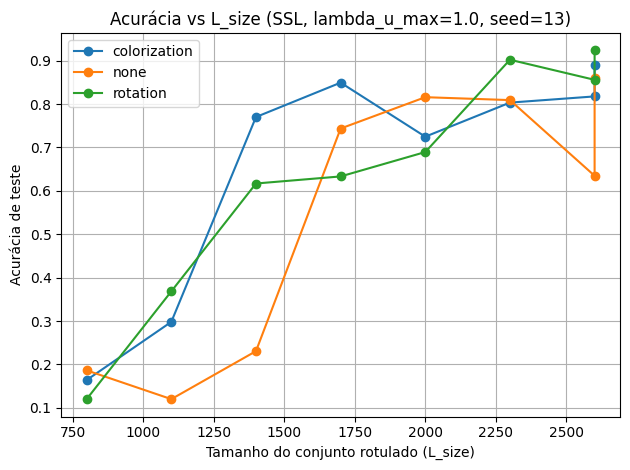

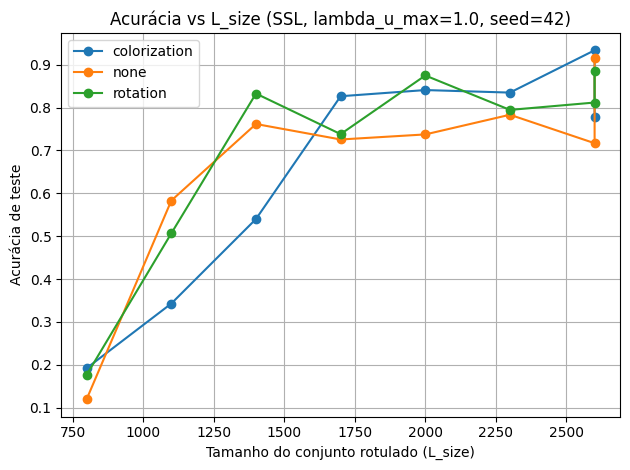

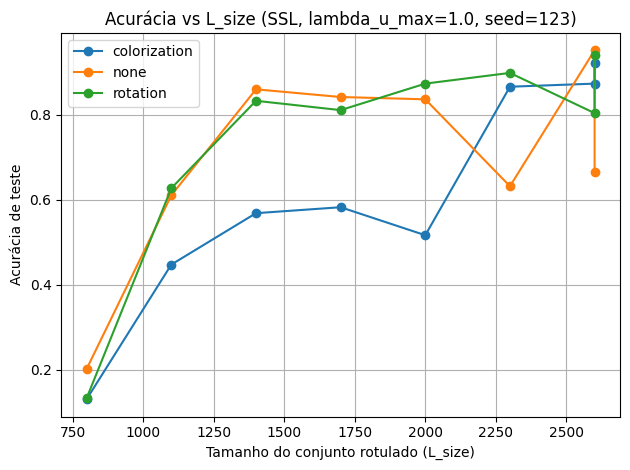

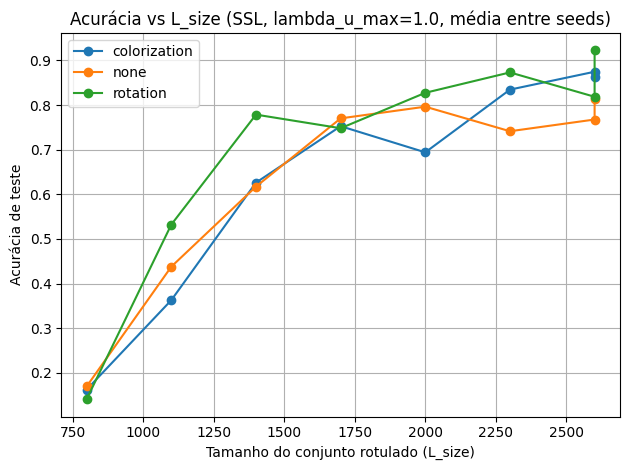

In [5]:
def plot_acc_vs_L(df, seed=None):
    """
    Plota test_acc vs L_size por round, separado por pretext_task,
    para lambda_u_max=1.0 (SSL). Se seed for None, usa todas as seeds com média.
    """
    data = df[df["lambda_u_max"] == 1.0].copy()
    if seed is not None:
        data = data[data["seed"] == seed]

    # Para o caso de várias seeds, vamos tirar média por round/pretext_task/L_size
    grouped = (
        data.groupby(["pretext_task", "round", "L_size"], as_index=False)
            .agg(mean_acc=("test_acc", "mean"),
                 std_acc=("test_acc", "std"))
    )

    plt.figure()
    for task in sorted(grouped["pretext_task"].unique()):
        sub = grouped[grouped["pretext_task"] == task]
        plt.plot(sub["L_size"], sub["mean_acc"], marker="o", label=task)
        # opcional: barras de desvio-padrão
        # plt.fill_between(sub["L_size"], sub["mean_acc"]-sub["std_acc"], sub["mean_acc"]+sub["std_acc"], alpha=0.2)

    plt.xlabel("Tamanho do conjunto rotulado (L_size)")
    plt.ylabel("Acurácia de teste")
    plt.title("Acurácia vs L_size (SSL, lambda_u_max=1.0{})".format(
        f", seed={seed}" if seed is not None else ", média entre seeds"
    ))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Uso:
plot_acc_vs_L(df, seed=13)
plot_acc_vs_L(df, seed=42) # olhar um seed específico
plot_acc_vs_L(df, seed=123)
plot_acc_vs_L(df)          # média entre seeds


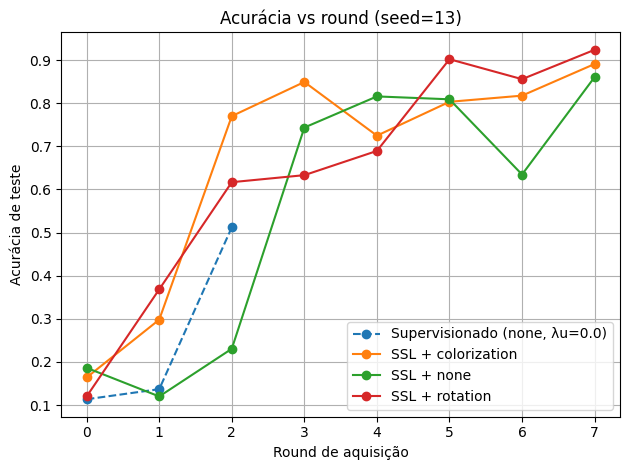

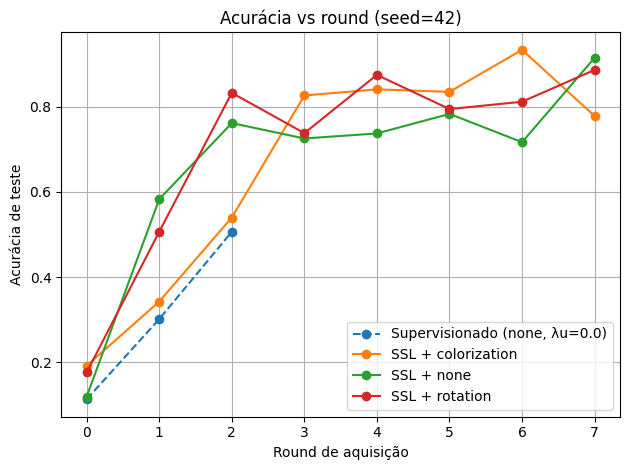

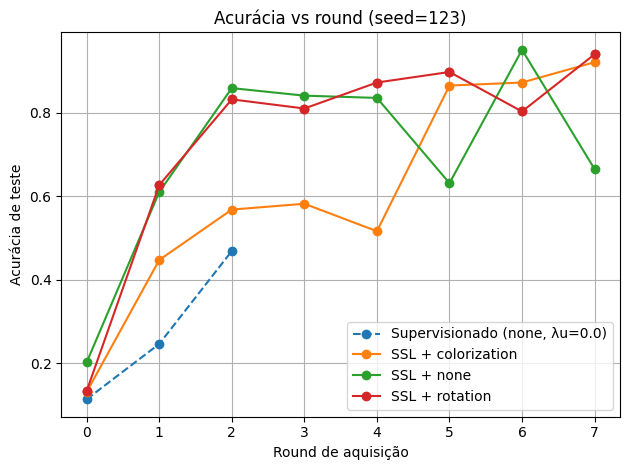

In [6]:
def plot_acc_vs_round(df, seed):
    """
    Compara curvas de acurácia por round para um seed fixo,
    separando baseline supervisionado e configs SSL.
    """
    plt.figure()

    # Supervisionado puro (lambda_u_max = 0.0)
    sup = df[(df["seed"] == seed) & (df["lambda_u_max"] == 0.0)]
    if not sup.empty:
        plt.plot(sup["round"], sup["test_acc"], marker="o", linestyle="--", label="Supervisionado (none, λu=0.0)")

    # SSL (lambda_u_max = 1.0), com diferentes pretexts
    ssl = df[(df["seed"] == seed) & (df["lambda_u_max"] == 1.0)]
    for task in sorted(ssl["pretext_task"].unique()):
        sub = ssl[ssl["pretext_task"] == task]
        plt.plot(sub["round"], sub["test_acc"], marker="o", label=f"SSL + {task}")

    plt.xlabel("Round de aquisição")
    plt.ylabel("Acurácia de teste")
    plt.title(f"Acurácia vs round (seed={seed})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Uso:
plot_acc_vs_round(df, seed=13)
plot_acc_vs_round(df, seed=42)
plot_acc_vs_round(df, seed=123)


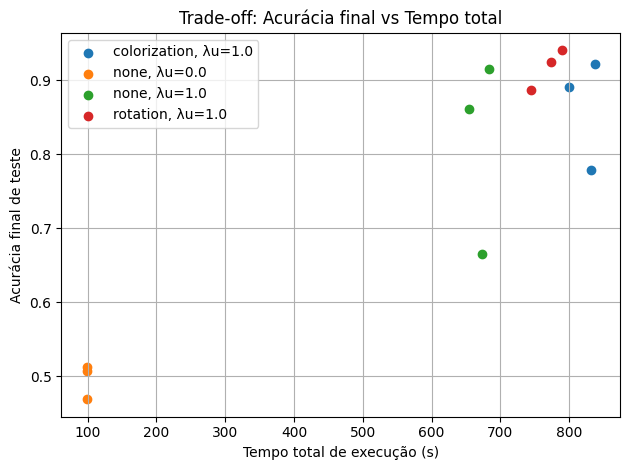

In [31]:
def plot_final_acc_vs_time(last_round):
    """
    Usa o DataFrame last_round (uma linha por seed/pretext_task/lambda_u_max)
    e plota acurácia final vs tempo total.
    """
    plt.figure()

    for (task, lam), sub in last_round.groupby(["pretext_task", "lambda_u_max"]):
        label = f"{task}, λu={lam}"
        plt.scatter(sub["total_secs"], sub["test_acc"], label=label)

    plt.xlabel("Tempo total de execução (s)")
    plt.ylabel("Acurácia final de teste")
    plt.title("Trade-off: Acurácia final vs Tempo total")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Uso:
plot_final_acc_vs_time(last_round)


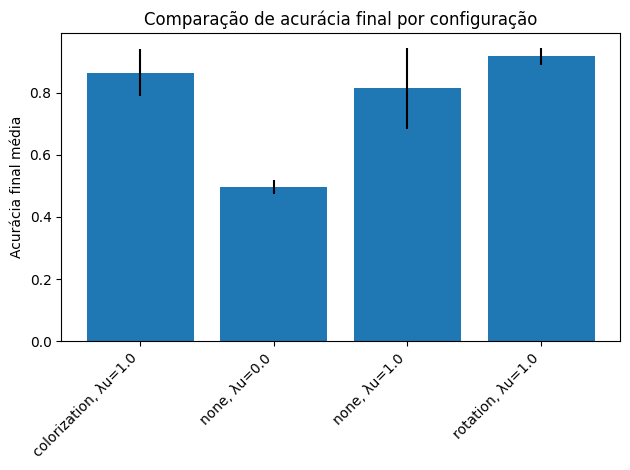

In [32]:
def bar_mean_acc(summary):
    """
    Usa o DataFrame summary (médias por pretext_task/lambda_u_max)
    para plotar barras de acurácia média final.
    """
    x_labels = []
    means = []
    stds = []

    for _, row in summary.iterrows():
        x_labels.append(f"{row['pretext_task']}, λu={row['lambda_u_max']}")
        means.append(row["mean_acc"])
        stds.append(row["std_acc"])

    plt.figure()
    x = range(len(x_labels))
    plt.bar(x, means, yerr=stds)
    plt.xticks(x, x_labels, rotation=45, ha="right")
    plt.ylabel("Acurácia final média")
    plt.title("Comparação de acurácia final por configuração")
    plt.tight_layout()
    plt.show()

# Uso:
bar_mean_acc(summary)
